In [8]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import datetime
from influxdb_client import InfluxDBClient

import time
start = time.time()

# Create a connection to InfluxDB
client = InfluxDBClient(
    url="http://localhost:8086",
    token="K9yF5FO1xXzr7z94Cb1TwBjtHZTejHoGz8fNtBsRXYQUVVwo3nU9UP__a6itxyVk0A9M7lgJAz70JQ0b_WiTuA==",
    org="Hariscope",
    bucket="WT_Scada",
)

query_api = client.query_api()

# Define your InfluxDB query
# Query the data from InfluxDB
query = """from(bucket: "WT_Scada")
  |> range(start: 2016-01-01T00:00:00Z, stop: 2017-01-01T00:00:00Z)
  |> filter(fn: (r) => r._measurement == "T06")
  |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
  |> yield()
"""

# Execute the query
results = client.query_api().query_data_frame(query)

# Convert the result to a Pandas DataFrame
data = pd.DataFrame(results)

# Close the InfluxDB connection
client.close()

# Print the DataFrame
#print(df.head())

#print(data['Amb_Temp_Avg'])

column_names = data.columns.tolist()
#print(column_names)

datetime_obj = pd.to_datetime(data['_time'])

data['timestamp'] = datetime_obj.dt.strftime('%Y-%m-%d %H:%M:%S')


In [9]:
#WILL COME BACK TO YOU

# Remove instances where turbine power is zero or less but wind speed is above cut-in speed
data = data[(data['Amb_WindSpeed_Max'] >= 3.5) & (data['Grd_Prod_Pwr_Avg'] > 0)]

# Remove samples where at least one input or output is missing
df = data.dropna()

# Split the data into training and testing sets
train = df[:int(0.7*len(data))]
test = df[int(0.7*len(data)):]

# Define the input and output variables
input_vars = ['Nac_Temp_Avg', 'Rtr_RPM_Avg', 'Prod_LatestAvg_TotActPwr', 'Amb_Temp_Avg', 'Gear_Oil_Temp_Avg']
output_var = 'Gear_Bear_Temp_Avg'


#print(train['timestamp'])
#print(test['timestamp'])


C:\Users\User\AppData\Local\Temp\ipykernel_6560\8080548.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'predicted'] = model.predict(test[input_vars])
C:\Users\User\AppData\Local\Temp\ipykernel_6560\8080548.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_filtered['timestamp'] = pd.to_datetime(test_filtered['timestamp'])


RMSE: 0.96
MAE: 0.72
MAPE: 1.33
R^2 Score: 0.97


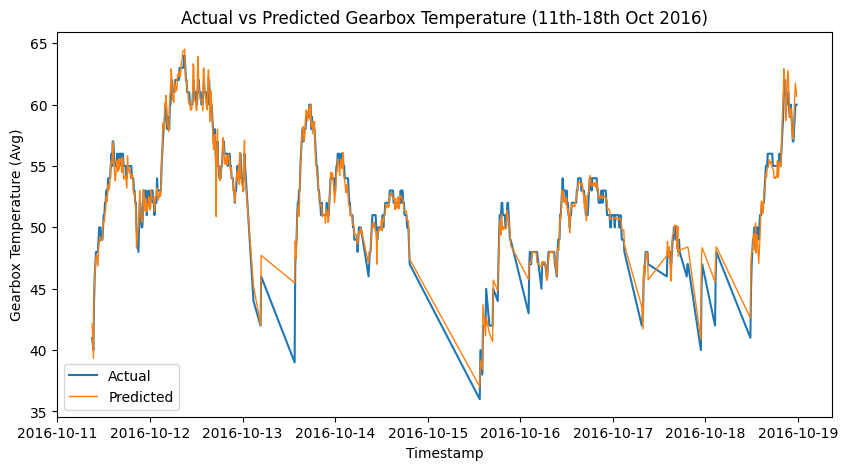

In [10]:
# Train the regression model
model = LinearRegression()
model.fit(train[input_vars], train[output_var])

# Predict on the testing set
#test['predicted'] = model.predict(test[input_vars])

test.loc[:, 'predicted'] = model.predict(test[input_vars])

# Calculate RMSE, MAE, and MAPE
rmse = np.sqrt(mean_squared_error(test[output_var], test['predicted']))
mae = mean_absolute_error(test[output_var], test['predicted'])
mape = np.mean(np.abs((test[output_var] - test['predicted']) / test[output_var])) * 100
r2 = r2_score(test[output_var], test['predicted'])

# Print the evaluation metrics
print('RMSE:', round(rmse, 2))
print('MAE:', round(mae, 2))
print('MAPE:', round(mape, 2))
print('R^2 Score:', round(r2, 2))


# Filter data between 11th and 18th October 2016
start_date = '2016-10-11 00:00'
end_date = '2016-10-18 23:50'
mask = (test['timestamp'] >= start_date) & (test['timestamp'] <= end_date)
test_filtered = test.loc[mask]

# Convert timestamp column to datetime type
test_filtered['timestamp'] = pd.to_datetime(test_filtered['timestamp'])

# Plot the actual vs predicted values for filtered data
plt.figure(figsize=(10,5))
plt.plot(test_filtered['timestamp'], test_filtered[output_var], label='Actual')
plt.plot(test_filtered['timestamp'], test_filtered['predicted'], label='Predicted', linewidth=1)
plt.xlabel('Timestamp')
plt.ylabel('Gearbox Temperature (Avg)')
plt.title('Actual vs Predicted Gearbox Temperature (11th-18th Oct 2016)')
plt.legend()

# Save the plot as a PNG file
plt.savefig('C:\\Users\\User\\Desktop\\Python\\Wind_Turbine_Gearbox\\MLR\\plot_results\\T06_2017_Jan_predictions.png')

plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_12476\3345621443.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_filtered['timestamp'] = pd.to_datetime(test_filtered['timestamp'])


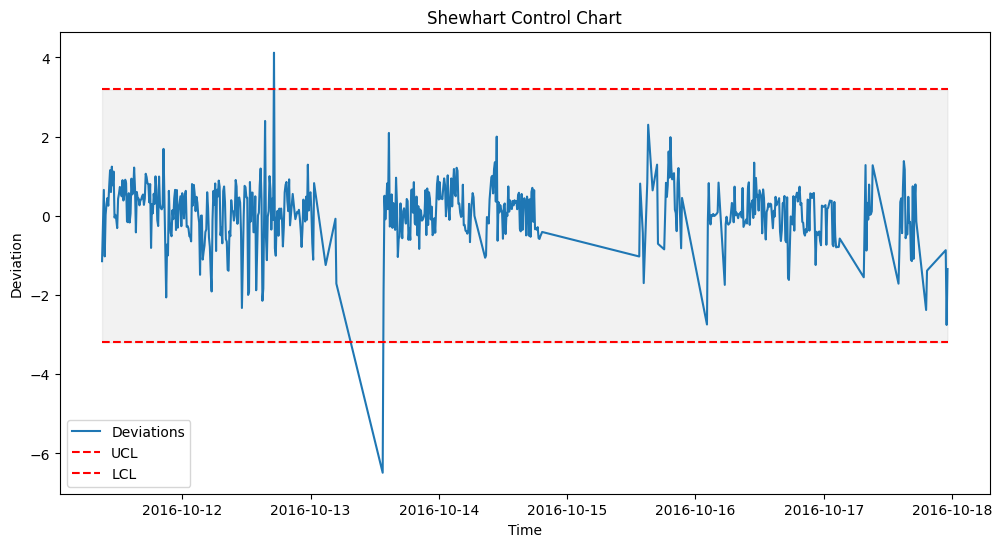

In [145]:
from sklearn.metrics import mean_squared_error
from scipy.stats import ttest_ind

#predict on test set
test.loc[:, 'predicted'] = model.predict(test[input_vars])

# Filter data between 11th and 18th October 2017
start_date = '2016-10-11 00:00'
end_date = '2016-10-18 00:00'
mask = (test['timestamp'] >= start_date) & (test['timestamp'] <= end_date)
test_filtered = test.loc[mask]

# Calculate the residual errors
deviations = test_filtered[output_var] - test_filtered['predicted']

mr = abs(deviations - deviations.shift(1))

sigma = mr.mean() / 1.128

ucl = 6 * sigma
lcl = -6 * sigma

within_limits = (deviations >= lcl) & (deviations <= ucl)

# Convert timestamp column to datetime type
test_filtered['timestamp'] = pd.to_datetime(test_filtered['timestamp'])

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(test_filtered['timestamp'], deviations, label='Deviations')
ax.plot(test_filtered['timestamp'], [ucl] * len(test_filtered), label='UCL', linestyle='--', color='red')
ax.plot(test_filtered['timestamp'], [lcl] * len(test_filtered), label='LCL', linestyle='--', color='red')
ax.fill_between(test_filtered['timestamp'], lcl, ucl, alpha=0.1, color='gray')
ax.legend(loc='best')
ax.set_xlabel('Time')
ax.set_ylabel('Deviation')
ax.set_title('Shewhart Control Chart')
plt.show()


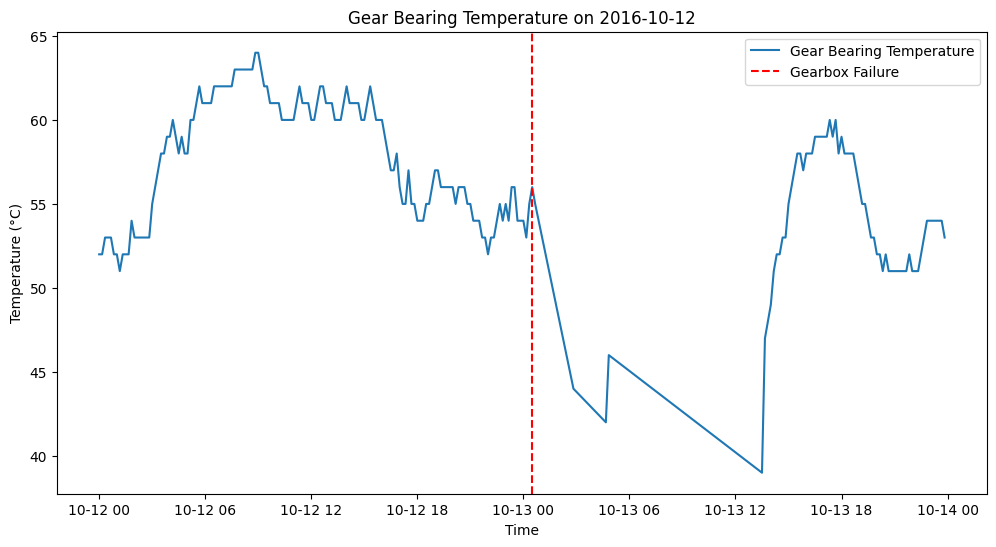

In [146]:
#HERE WE FIND THE POINT OF FAILURE OF GEARBOX BASED ON INFORMATION FORM THE FAILURE LOGS

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import date2num

# Load the preprocessed data
#df = pd.read_csv('T06_2017_WT_DATA_Final.txt')

# HERE WE NEED TO USE DATA INSTEAD BECAUSE THE DATA WAS GOTTEN FROM INFLUX DB******

# Convert timestamp column to datetime format
data['timestamp'] = pd.to_datetime(data['timestamp'])

data.set_index('timestamp', inplace=True)

# Filter data for 2017-10-12 to 13
start_date = '2016-10-12 00:00:00'
end_date = '2016-10-13 23:59:59'
df_filtered = data.loc[start_date:end_date]

# Convert the datetime string to a numerical value
x_value = date2num(pd.to_datetime('2016-10-13 00:30:00'))

# Plot the data
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_filtered.index, df_filtered['Gear_Bear_Temp_Avg'], label='Gear Bearing Temperature')
ax.axvline(x=x_value, color='r', linestyle='--', label='Gearbox Failure')
ax.legend(loc='best')
ax.set_xlabel('Time')
ax.set_ylabel('Temperature (°C)')
ax.set_title('Gear Bearing Temperature on 2016-10-12')
plt.show()


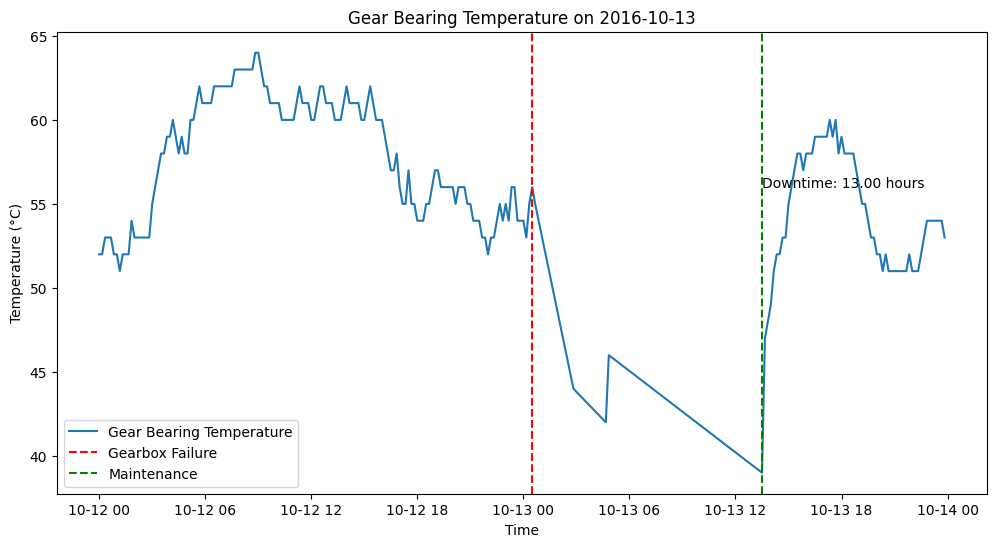

In [147]:
#HERE WE FIND THE DOWNTIME BY ADDING CODE TO GET THE MAINTENANCE TIME OF GEARBOX

failure_time = pd.to_datetime('2016-10-13 00:30:00')

# Find the time of maintenance
#maintenance_time_mask = (df_filtered['Gear_Bear_Temp_Avg'] < 50) & (df_filtered.index > failure_time)
#maintenance_time = df_filtered[maintenance_time_mask].index[0]
#maintenance_time_num = date2num(maintenance_time)
# Find the time of maintenance
lowest_temp_since_failure = df_filtered[df_filtered.index >= failure_time]['Gear_Bear_Temp_Avg'].min()
maintenance_time_mask = (df_filtered['Gear_Bear_Temp_Avg'] == lowest_temp_since_failure) & (df_filtered.index > failure_time)
maintenance_time = df_filtered[maintenance_time_mask].index[0]
maintenance_time_num = date2num(maintenance_time)


# Calculate the downtime duration
downtime_hours = (maintenance_time - pd.to_datetime('2016-10-13 00:30:00')).total_seconds() / 3600

# Plot the data
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_filtered.index, df_filtered['Gear_Bear_Temp_Avg'], label='Gear Bearing Temperature')
ax.axvline(x=x_value, color='r', linestyle='--', label='Gearbox Failure')
ax.axvline(x=maintenance_time_num, color='g', linestyle='--', label='Maintenance')
ax.legend(loc='best')
ax.set_xlabel('Time')
ax.set_ylabel('Temperature (°C)')
ax.set_title('Gear Bearing Temperature on 2016-10-13')
plt.text(maintenance_time_num, 56, f'Downtime: {downtime_hours:.2f} hours')
plt.show()


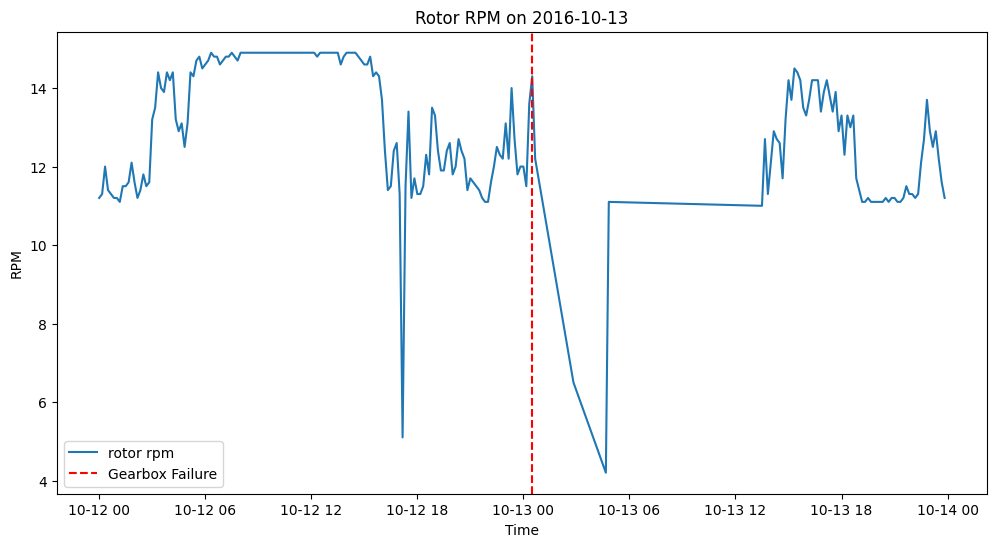

In [148]:
#HERE WE FIND THE behaviour of other componenets AT POINT OF FAILURE OF GEARBOX BASED ON INFORMATION FORM THE FAILURE LOGS

# Plot the data
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_filtered.index, df_filtered['Rtr_RPM_Avg'], label='rotor rpm')
ax.axvline(x=x_value, color='r', linestyle='--', label='Gearbox Failure')
ax.legend(loc='best')
ax.set_xlabel('Time')
ax.set_ylabel('RPM')
ax.set_title('Rotor RPM on 2016-10-13')
plt.show()

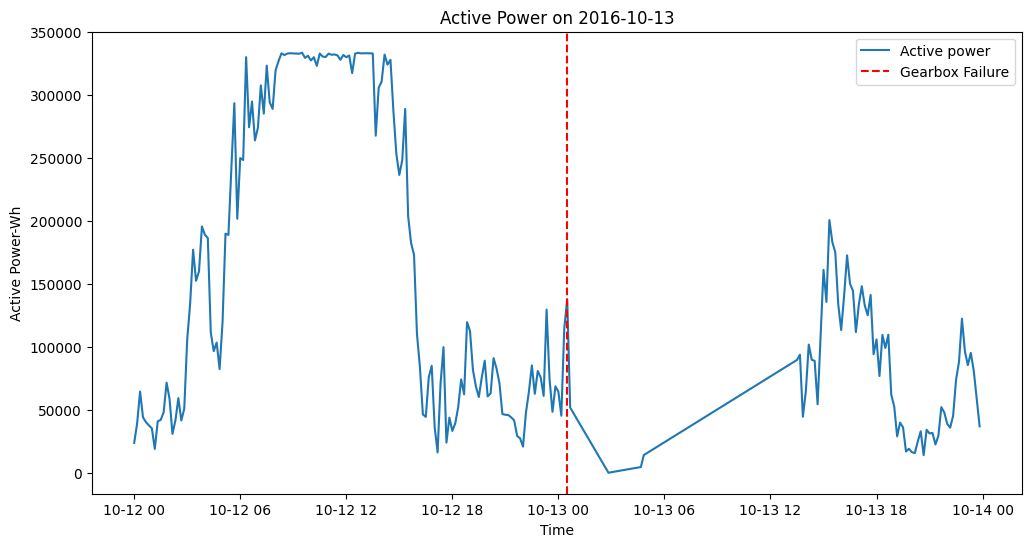

In [149]:
# Plot the data
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_filtered.index, df_filtered['Prod_LatestAvg_TotActPwr'], label='Active power')
ax.axvline(x=x_value, color='r', linestyle='--', label='Gearbox Failure')
ax.legend(loc='best')
ax.set_xlabel('Time')
ax.set_ylabel('Active Power-Wh')
ax.set_title('Active Power on 2016-10-13')
plt.show()

In [150]:
print(test[input_vars])

       Nac_Temp_Avg  Rtr_RPM_Avg  Prod_LatestAvg_TotActPwr  Amb_Temp_Avg   
35100          32.0         11.1                   20950.0          22.0  \
35101          32.0         11.1                   21696.0          22.0   
35102          32.0         11.1                   15804.0          22.0   
35103          32.0         10.0                    8293.0          22.0   
35104          32.0          8.4                    2011.0          22.0   
...             ...          ...                       ...           ...   
50564          25.0         11.2                   42224.0          14.0   
50565          25.0         11.2                   40117.0          14.0   
50566          25.0         11.2                   45615.0          14.0   
50567          25.0         11.2                   47126.0          14.0   
50568          25.0         11.2                   43721.0          14.0   

       Gear_Oil_Temp_Avg  
35100               46.0  
35101               46.0  
35102 

Gearbox temperature spiked above UCL at:
Datetime: 2016-10-12 15:30:00, Deviation: 2.40, Temperature: 61.00
Datetime: 2016-10-12 17:10:00, Deviation: 4.12, Temperature: 55.00


C:\Users\User\AppData\Local\Temp\ipykernel_12476\379603338.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_filtered['timestamp'] = pd.to_datetime(test_filtered['timestamp'])


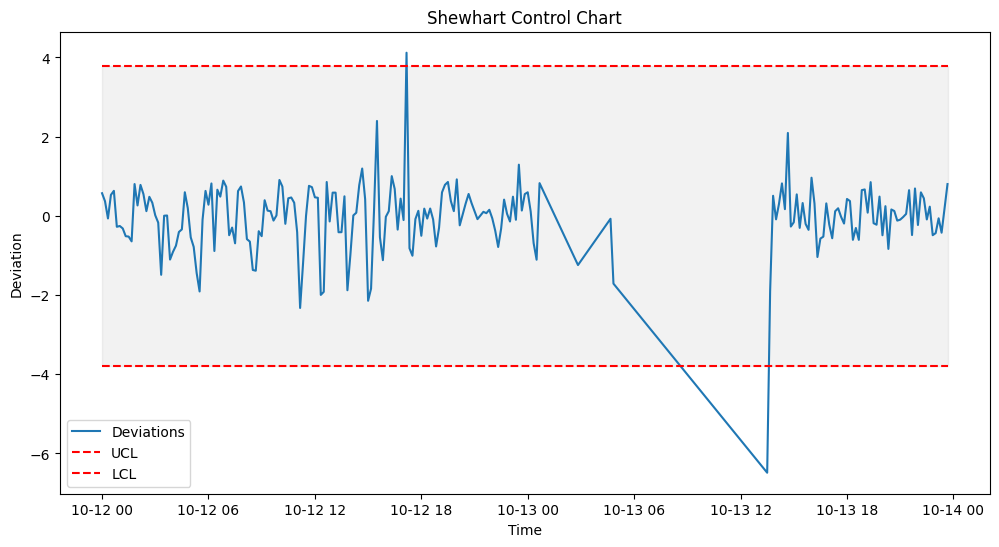

In [151]:
#predict on test set
test.loc[:, 'predicted'] = model.predict(test[input_vars])

# Filter data between 12th and 13th October 2016
start_date = '2016-10-12 00:00'
end_date = '2016-10-13 23:50'
mask = (test['timestamp'] >= start_date) & (test['timestamp'] <= end_date)
test_filtered = test.loc[mask]

# Calculate the residual errors
deviations = test_filtered[output_var] - test_filtered['predicted']

mr = abs(deviations - deviations.shift(1))

sigma = mr.mean() / 1.128

ucl = 6 * sigma
lcl = -6 * sigma

# Find the time and temperature where Gearbox temperature spiked above UCL
spikes_above_ucl = test_filtered[test_filtered['Gear_Bear_Temp_Avg'] > 50]
if not spikes_above_ucl.empty:
    print('Gearbox temperature spiked above UCL at:')
    for index, row in spikes_above_ucl.iterrows():
        deviation_time = row['timestamp']
        deviation_value = deviations.loc[index]


        #if deviation_value > 3:
        if row['Gear_Bear_Temp_Avg'] > 50 and deviation_value > 2.3:
            print(f'Datetime: {deviation_time}, Deviation: {deviation_value:.2f}, Temperature: {row["Gear_Bear_Temp_Avg"]:.2f}')

within_limits = (deviations >= lcl) & (deviations <= ucl)

# Convert timestamp column to datetime type
test_filtered['timestamp'] = pd.to_datetime(test_filtered['timestamp'])

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(test_filtered['timestamp'], deviations, label='Deviations')
ax.plot(test_filtered['timestamp'], [ucl] * len(test_filtered), label='UCL', linestyle='--', color='red')
ax.plot(test_filtered['timestamp'], [lcl] * len(test_filtered), label='LCL', linestyle='--', color='red')
ax.fill_between(test_filtered['timestamp'], lcl, ucl, alpha=0.1, color='gray')
ax.legend(loc='best')
ax.set_xlabel('Time')
ax.set_ylabel('Deviation')
ax.set_title('Shewhart Control Chart')
plt.show()


In [152]:
# NOW LETS GET THE 2017 DATA ADDED TO 2016 TO OUR DATAFRAME

my_token = "K9yF5FO1xXzr7z94Cb1TwBjtHZTejHoGz8fNtBsRXYQUVVwo3nU9UP__a6itxyVk0A9M7lgJAz70JQ0b_WiTuA=="
my_org = "Hariscope"
bucket = "WT_Scada"

#client = InfluxDBClient(url="http://localhost:8086", token=my_token, )

# Create a connection to InfluxDB
client = InfluxDBClient(
    url="http://localhost:8086",
    token="K9yF5FO1xXzr7z94Cb1TwBjtHZTejHoGz8fNtBsRXYQUVVwo3nU9UP__a6itxyVk0A9M7lgJAz70JQ0b_WiTuA==",
    org="Hariscope",
    bucket="WT_Scada",
)

query_api = client.query_api()

# Define your InfluxDB query
# Query the data from InfluxDB
query2 = """from(bucket: "WT_Scada")
  |> range(start: 2017-01-01T00:00:00Z, stop: 2018-01-01T00:00:00Z)
  |> filter(fn: (r) => r._measurement == "T06")
  |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
  |> yield()
"""

# Execute the query
results2 = client.query_api().query_data_frame(query2)

# Convert the result to a Pandas DataFrame
data2 = pd.DataFrame(results2)

# Close the InfluxDB connection
client.close()

print(data2['Amb_Temp_Avg'])

column_names = data2.columns.tolist()
print(column_names)

datetime_obj = pd.to_datetime(data2['_time'])

data2['timestamp'] = datetime_obj.dt.strftime('%Y-%m-%d %H:%M:%S')

print(data2['timestamp'])


0       14.0
1       14.0
2       14.0
3       14.0
4       14.0
        ... 
4459    15.0
4460    14.0
4461    14.0
4462    14.0
4463    14.0
Name: Amb_Temp_Avg, Length: 4464, dtype: float64
['result', 'table', '_start', '_stop', '_time', '_measurement', 'asset', 'Amb_Temp_Avg', 'Amb_WindSpeed_Max', 'Gear_Bear_Temp_Avg', 'Gear_Oil_Temp_Avg', 'Gen_Bear2_Temp_Avg', 'Gen_Bear_Temp_Avg', 'Gen_Phase1_Temp_Avg', 'Gen_Phase2_Temp_Avg', 'Gen_Phase3_Temp_Avg', 'Gen_RPM_Avg', 'Grd_Prod_Pwr_Avg', 'Nac_Temp_Avg', 'Prod_LatestAvg_TotActPwr', 'Rtr_RPM_Avg']
0       2017-01-01 00:00:00
1       2017-01-01 00:10:00
2       2017-01-01 00:20:00
3       2017-01-01 00:30:00
4       2017-01-01 00:40:00
               ...         
4459    2017-01-31 23:10:00
4460    2017-01-31 23:20:00
4461    2017-01-31 23:30:00
4462    2017-01-31 23:40:00
4463    2017-01-31 23:50:00
Name: timestamp, Length: 4464, dtype: object


In [153]:
#***WORKING WITH 2017 DATA***


# Remove instances where turbine power is zero or less but wind speed is above cut-in speed
data2 = data2[(data2['Amb_WindSpeed_Max'] >= 3.5) & (data2['Grd_Prod_Pwr_Avg'] > 0)]

# Remove samples where at least one input or output is missing
df = data2.dropna()

# Split the data into training and testing sets
#train = df[:int(0.7*len(data))]
#test = df[int(0.7*len(data)):]

# Define the input and output variables
input_vars = ['Nac_Temp_Avg', 'Rtr_RPM_Avg', 'Prod_LatestAvg_TotActPwr', 'Amb_Temp_Avg', 'Gear_Oil_Temp_Avg']
output_var = 'Gear_Bear_Temp_Avg'


print(df[input_vars])



      Nac_Temp_Avg  Rtr_RPM_Avg  Prod_LatestAvg_TotActPwr  Amb_Temp_Avg   
0             24.0         11.7                   63087.0          14.0  \
1             24.0         11.6                   57354.0          14.0   
2             24.0         11.4                   52931.0          14.0   
3             24.0         11.3                   45917.0          14.0   
4             24.0         11.2                   38160.0          14.0   
...            ...          ...                       ...           ...   
4459          26.0         13.0                   98784.0          15.0   
4460          26.0         11.8                   69079.0          14.0   
4461          26.0         11.2                   42338.0          14.0   
4462          25.0         11.1                   27096.0          14.0   
4463          25.0         11.1                   21424.0          14.0   

      Gear_Oil_Temp_Avg  
0                  47.0  
1                  47.0  
2                  47

RMSE: 1.04
MAE: 0.81
MAPE: 1.59
R^2 Score: 0.97


C:\Users\User\AppData\Local\Temp\ipykernel_12476\3907301008.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_filtered['timestamp'] = pd.to_datetime(test_filtered['timestamp'])


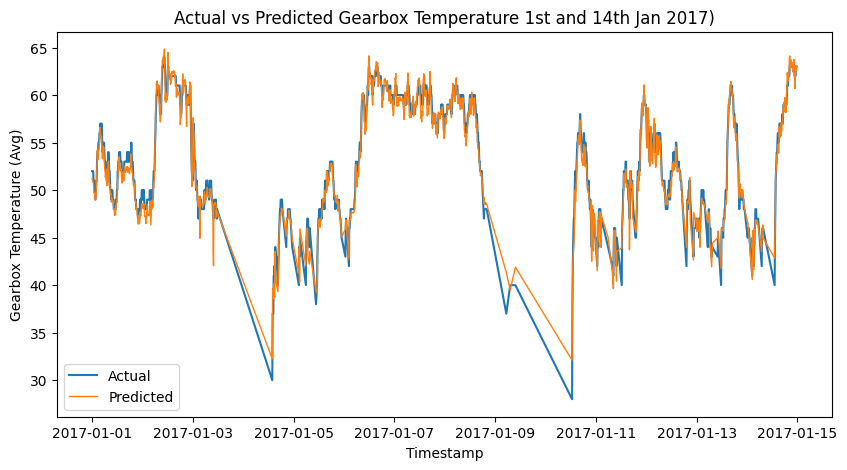

In [154]:
# Now predict on 2017 data

df.loc[:, 'predicted'] = model.predict(df[input_vars])

# Calculate RMSE, MAE, and MAPE
rmse = np.sqrt(mean_squared_error(df[output_var], df['predicted']))
mae = mean_absolute_error(df[output_var], df['predicted'])
mape = np.mean(np.abs((df[output_var] - df['predicted']) / df[output_var])) * 100
r2 = r2_score(df[output_var], df['predicted'])

# Print the evaluation metrics
print('RMSE:', round(rmse, 2))
print('MAE:', round(mae, 2))
print('MAPE:', round(mape, 2))
print('R^2 Score:', round(r2, 2))


# Filter data between 11th and 18th October 2017
start_date = '2017-01-01 00:00'
end_date = '2017-01-14 23:50'
mask = (df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)
test_filtered = df.loc[mask]

# Convert timestamp column to datetime type
test_filtered['timestamp'] = pd.to_datetime(test_filtered['timestamp'])

# Plot the actual vs predicted values for filtered data
plt.figure(figsize=(10,5))
plt.plot(test_filtered['timestamp'], test_filtered[output_var], label='Actual')
plt.plot(test_filtered['timestamp'], test_filtered['predicted'], label='Predicted', linewidth=1)
plt.xlabel('Timestamp')
plt.ylabel('Gearbox Temperature (Avg)')
plt.title('Actual vs Predicted Gearbox Temperature 1st and 14th Jan 2017)')
plt.legend()
plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_12476\3888747981.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_filtered['timestamp'] = pd.to_datetime(test_filtered['timestamp'])


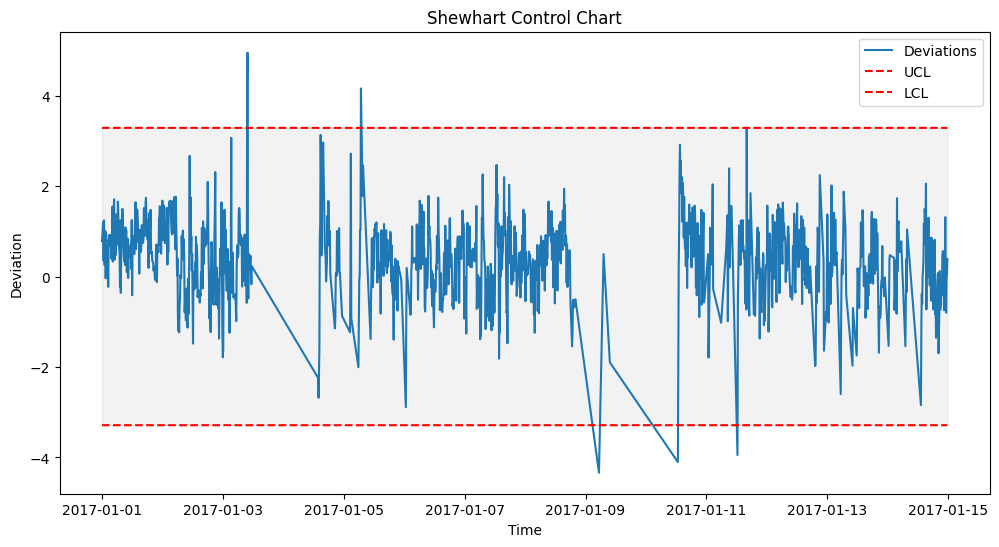

In [155]:
# Calculate the residual errors
deviations = test_filtered[output_var] - test_filtered['predicted']

mr = abs(deviations - deviations.shift(1))

sigma = mr.mean() / 1.128

ucl = 6 * sigma
lcl = -6 * sigma

within_limits = (deviations >= lcl) & (deviations <= ucl)

# Convert timestamp column to datetime type
test_filtered['timestamp'] = pd.to_datetime(test_filtered['timestamp'])

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(test_filtered['timestamp'], deviations, label='Deviations')
ax.plot(test_filtered['timestamp'], [ucl] * len(test_filtered), label='UCL', linestyle='--', color='red')
ax.plot(test_filtered['timestamp'], [lcl] * len(test_filtered), label='LCL', linestyle='--', color='red')
ax.fill_between(test_filtered['timestamp'], lcl, ucl, alpha=0.1, color='gray')
ax.legend(loc='best')
ax.set_xlabel('Time')
ax.set_ylabel('Deviation')
ax.set_title('Shewhart Control Chart')
plt.show()


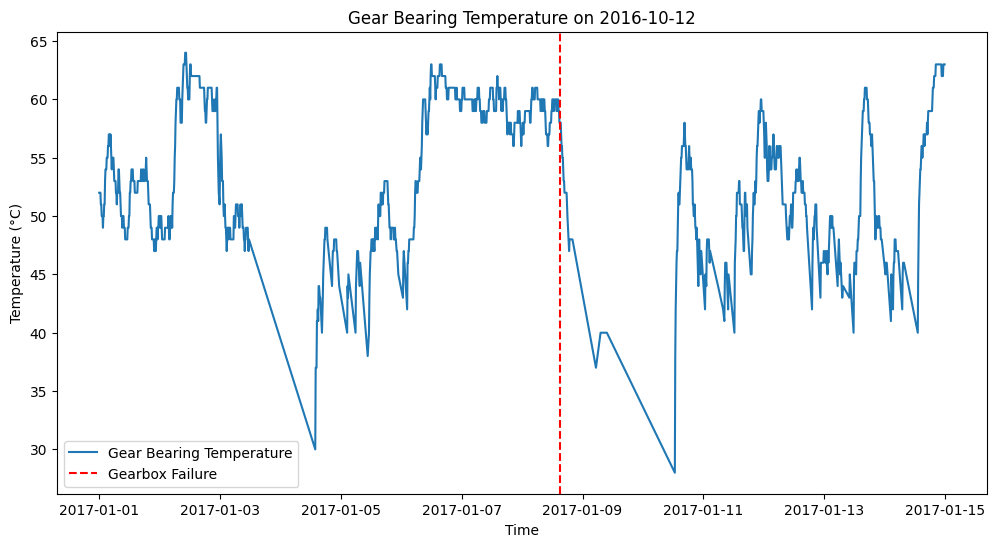

In [156]:
#HERE WE FIND THE POINT OF FAILURE OF GEARBOX BASED ON INFORMATION FORM THE FAILURE LOGS

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import date2num

# Load the preprocessed data
#df = pd.read_csv('T06_2017_WT_DATA_Final.txt')

# HERE WE NEED TO USE DATA INSTEAD BECAUSE THE DATA WAS GOTTEN FROM INFLUX DB******

# Convert timestamp column to datetime format
data2['timestamp'] = pd.to_datetime(data2['timestamp'])

data2.set_index('timestamp', inplace=True)

# Filter data for 2017-10-12 to 13
start_date = '2017-01-01 00:00:00'
end_date = '2017-01-14 23:59:59'
df_filtered = data2.loc[start_date:end_date]

# Convert the datetime string to a numerical value
x_value = date2num(pd.to_datetime('2017-01-08 15:00:00'))

# Plot the data
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_filtered.index, df_filtered['Gear_Bear_Temp_Avg'], label='Gear Bearing Temperature')
ax.axvline(x=x_value, color='r', linestyle='--', label='Gearbox Failure')
ax.legend(loc='best')
ax.set_xlabel('Time')
ax.set_ylabel('Temperature (°C)')
ax.set_title('Gear Bearing Temperature on 2016-10-12')
plt.show()

Gearbox temperature spiked above UCL at:
Datetime: 2017-01-02 10:50:00, Deviation: 2.67, Temperature: 62.00
Datetime: 2017-01-02 21:00:00, Deviation: 2.31, Temperature: 59.00
Datetime: 2017-01-07 12:40:00, Deviation: 2.47, Temperature: 60.00


C:\Users\User\AppData\Local\Temp\ipykernel_12476\1187509287.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_filtered['timestamp'] = pd.to_datetime(test_filtered['timestamp'])


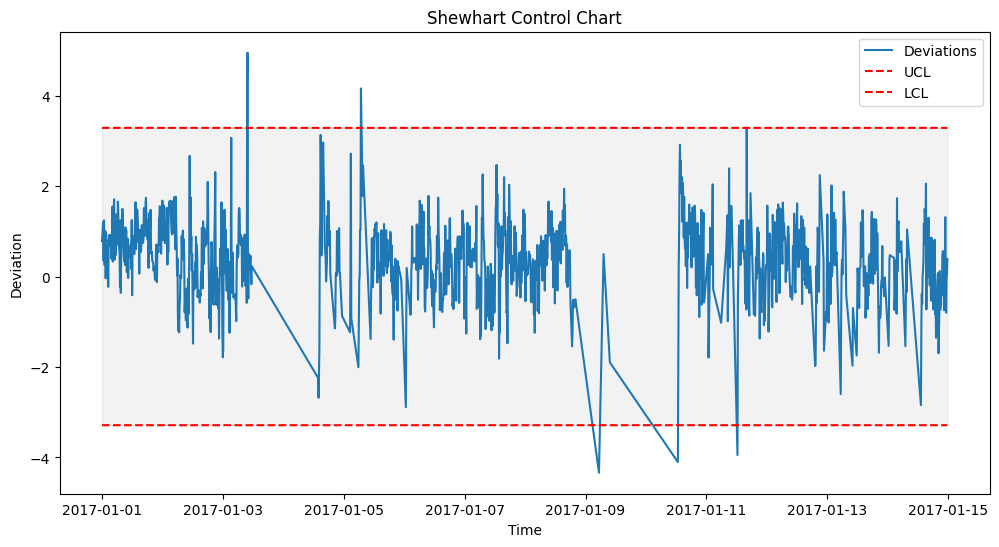

In [161]:
df.loc[:, 'predicted'] = model.predict(df[input_vars])

# Filter data between 11th and 18th October 2017
start_date = '2017-01-01 00:00'
end_date = '2017-01-14 23:50'
mask = (df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)
test_filtered = df.loc[mask]

# Calculate the residual errors
deviations = test_filtered[output_var] - test_filtered['predicted']

mr = abs(deviations - deviations.shift(1))

sigma = mr.mean() / 1.128

ucl = 6 * sigma
lcl = -6 * sigma

# Find the time and temperature where Gearbox temperature spiked above UCL
spikes_above_ucl = test_filtered[test_filtered['Gear_Bear_Temp_Avg'] > 50]
if not spikes_above_ucl.empty:
    print('Gearbox temperature spiked above UCL at:')
    for index, row in spikes_above_ucl.iterrows():
        deviation_time = row['timestamp']
        deviation_value = deviations.loc[index]


        #if deviation_value > 3:
        if row['Gear_Bear_Temp_Avg'] > 50 and deviation_value > 2.3:
            print(f'Datetime: {deviation_time}, Deviation: {deviation_value:.2f}, Temperature: {row["Gear_Bear_Temp_Avg"]:.2f}')

within_limits = (deviations >= lcl) & (deviations <= ucl)

# Convert timestamp column to datetime type
test_filtered['timestamp'] = pd.to_datetime(test_filtered['timestamp'])

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(test_filtered['timestamp'], deviations, label='Deviations')
ax.plot(test_filtered['timestamp'], [ucl] * len(test_filtered), label='UCL', linestyle='--', color='red')
ax.plot(test_filtered['timestamp'], [lcl] * len(test_filtered), label='LCL', linestyle='--', color='red')
ax.fill_between(test_filtered['timestamp'], lcl, ucl, alpha=0.1, color='gray')
ax.legend(loc='best')
ax.set_xlabel('Time')
ax.set_ylabel('Deviation')
ax.set_title('Shewhart Control Chart')
plt.show()